# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 5I
+ 5J
+ 5L
+ S5K
+ S5L
+ S5M
+ S5N

#### Archives:
+ Transcription_ORC-DNA_ATP.yama
+ Transcription_ORC-DNA_ATP_stuck-ORC.yama
+ Transcription_ORC-DNA_T7T_ATP.yama
+ Transcription_ORC-DNA_T7T_ATP_stuck-ORC.yama
+ Transcription_naked-DNA_ATP_LD555.yama
+ Transcription_naked-DNA_ATP_LD655.yama
+ Transcription_naked-DNA_ATP_AF488.yama
+ Transcription_naked-DNA_T7T_ATP.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, SingleMoleculeArchive, instantiate_archive, describe_archives
from scipy.stats import norm
from tqdm.notebook import tqdm
from functools import reduce
from collections import Counter

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_ORC-DNA_ATP.yama',
                     'Transcription_ORC-DNA_ATP_stuck-ORC.yama',
                     'Transcription_ORC-DNA_T7T_ATP.yama',
                     'Transcription_ORC-DNA_T7T_ATP_stuck-ORC.yama',
                     'Transcription_naked-DNA_ATP_LD555.yama',
                     'Transcription_naked-DNA_ATP_LD655.yama',
                     'Transcription_naked-DNA_ATP_AF488.yama',
                     'Transcription_naked-DNA_T7T_ATP.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a
cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_ORC-DNA_ATP,1,206,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_ORC-DNA_T7T_ATP,3,612,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,True,passed
Transcription_naked-DNA_ATP_LD555,6,303,ybbR-LD555-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATP_LD655,1,281,ybbR-LD655-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_ATP_AF488,1,129,SNAP-AF488-T7,ATP,False,n/a,False,passed
Transcription_naked-DNA_T7T_ATP,1,325,ybbR-LD655-T7,ATP,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 5 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")           

# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)
                    
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          ORC_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
tQZAZhjj8Kodbg69hpUw64           92383.0     72.0           0.0      NaN   
tqXicVtpV4xrQsVhYVxKWb           42317.3     32.0           0.0      NaN   
gGq4WfJ5PC7N45pBqRTxz3           52218.7     38.0           0.0      NaN   
6SGDWFPX9eHZTg2DHcEGFF           29540.6    110.0           NaN      NaN   
iQFUAKZykqmHgQXzA6cJSt           17516.3    147.0           NaN      NaN   

molecule                                                                    \
properties                                        start_site     stop_site   
properties_details     position_on_dna recovery                              
tQZAZhjj8Kodbg69hpUw64             NaN      NaN  4876.398054  21485.670183   
tqXicVtpV4xrQsVhYVxKWb             NaN      NaN  3463.113266   9731.999655   
gGq4WfJ5PC7N45pBqRTxz3             NaN      NaN  4721.798711  13274.841442   
6SGDWFPX9eHZTg2DHcEGFF             NaN      NaN  5953.443253   6223.623638   
iQFUAKZykqmHgQXzA6cJSt             NaN      NaN  5783.339329   6486.449590   

molecule                          ORC_2_           ... hs_wash   label_ORC  \
properties             initial_intensity lifetime  ...                       
properties_details                                 ...                       
tQZAZhjj8Kodbg69hpUw64               NaN      NaN  ...   False  SORT-LD555   
tqXicVtpV4xrQsVhYVxKWb               NaN      NaN  ...   False  SORT-LD555   
gGq4WfJ5PC7N45pBqRTxz3               NaN      NaN  ...   False  SORT-LD555   
6SGDWFPX9eHZTg2DHcEGFF               NaN      NaN  ...   False  SORT-LD555   
iQFUAKZykqmHgQXzA6cJSt               NaN      NaN  ...   False  SORT-LD555   

molecule                  label_T7 nucleotide number_ORC number_T7  \
properties                                                           
properties_details                                                   
tQZAZhjj8Kodbg69hpUw64  ybbR-LD655        ATP        1.0       1.0   
tqXicVtpV4xrQsVhYVxKWb  ybbR-LD655        ATP        1.0       1.0   
gGq4WfJ5PC7N45pBqRTxz3  ybbR-LD655        ATP        1.0       0.0   
6SGDWFPX9eHZTg2DHcEGFF  ybbR-LD655        ATP        1.0       1.0   
iQFUAKZykqmHgQXzA6cJSt  ybbR-LD655        ATP        1.0       0.0   

molecule               t7_terminator  \
properties                             
properties_details                     
tQZAZhjj8Kodbg69hpUw64         False   
tqXicVtpV4xrQsVhYVxKWb         False   
gGq4WfJ5PC7N45pBqRTxz3         False   
6SGDWFPX9eHZTg2DHcEGFF         False   
iQFUAKZykqmHgQXzA6cJSt         False   

molecule                                                             tags  \
properties                                                                  
properties_details                                                          
tQZAZhjj8Kodbg69hpUw64     [representative, accept, coll_T7_1_ORC_1_push]   
tqXicVtpV4xrQsVhYVxKWb  [accept, coll_T7_1_ORC_1_push, coloc_T7_1_ORC_...   
gGq4WfJ5PC7N45pBqRTxz3                               [accept, ORC_1_push]   
6SGDWFPX9eHZTg2DHcEGFF                   [accept, coll_T7_1_ORC_1_bypass]   
iQFUAKZykqmHgQXzA6cJSt                                           [accept]   

molecule               velocity_ORC velocity_T7  
properties                                       
properties_details                               
tQZAZhjj8Kodbg69hpUw64    57.460327   56.853291  
tqXicVtpV4xrQsVhYVxKWb    51.893250   51.713341  
gGq4WfJ5PC7N45pBqRTxz3    54.663485         NaN  
6SGDWFPX9eHZTg2DHcEGFF          NaN   49.632027  
iQFUAKZykqmHgQXzA6cJSt          NaN         NaN  

[5 rows x 36 columns]

## Figures

 ### Figure 5I: Collision outcomes RNAP-ORC
*Note*: only consider archives with valid DNA count

In [14]:
colls = list()

for archive in filter(lambda archive: archive.dna_count_valid, DnaMoleculeArchive.instances):
    for molecule in archive.molecules:
        for tag in filter(lambda tag: 'coll_T7_1_ORC_' in tag, molecule.tags):
            colls.append(tag.split('_')[-1])

df_coll = pd.DataFrame(index=['outcome'],data=([Counter(colls)])).T
#df_coll.columns.names = ['hs_challenge']
df_coll

,outcome
push,125
bypass,57
pause,3
T7eject,25
stall,10
ORCeject,41
T7eject-ORCeject,4


In [15]:
df_coll = df_coll.reindex(['push', 'bypass','pause', 'stall', 'T7eject','ORCeject','T7eject-ORCeject'])
df_coll

,outcome
push,125
bypass,57
pause,3
stall,10
T7eject,25
ORCeject,41
T7eject-ORCeject,4


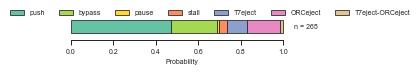

In [16]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(4,0.5))

(df_coll/df_coll.sum()).T.plot(kind='barh',stacked=True,ax=axes,rot=0,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][4],
                                      palettes['qualitative'][5],palettes['qualitative'][1],
                                      palettes['qualitative'][2],palettes['qualitative'][3],
                                      palettes['qualitative'][6]])

axes.set_xlabel("Probability")

#axes.set_title("Fate upon T7RNAP-MCM collision")
axes.set_xlim([0,1.05])
axes.set_yticks([])

labels = [int(df_coll.sum()[col]) for col in df_coll.columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(1.05, rect.get_y() + rect.get_height()/2, s=f'n = {label}', ha='left', va='center')
    counter+=1
axes.legend(ncol=len(df.index),bbox_to_anchor=[-0.3, 1], loc='center left',frameon=False)

#tidy up
#fig.tight_layout()
sns.despine(trim=True,left=True)

#save
plt.savefig(dir_out+'5I_ORC_collision_fate.svg',transparent=True)


### Figure 5J: Transcription rate +/- ORC

In [17]:
df_push = pd.DataFrame(columns=['initial_intensity','velocity'])

# loop through all archives with nucleotide ATPgS (just sanity check, only "ATPgS archives selected")
for archive in filter(lambda archive: archive.nucleotide == 'ATP',DnaMoleculeArchive.instances):

    # loop through all molecules
    for molecule in archive.molecules:
        #print('processing molecule:', molecule.uid)
        valid = True
        
        for protein, number in molecule.proteins.items():
            # make sure molecule only contains MCM & T7 
            if (number > 0 and protein not in {'T7', 'ORC'}):
                valid = False
                continue
            # more than 1 T7 or ORC (just a sanity check, shouldn't happen)
            elif number > 1:
                valid = False
                continue
                
        # loop through all seg_dfs with T7 in prefix
        if valid:
            for seg_df in filter(lambda seg_df: 'T7' in seg_df.prefix, molecule.seg_dfs):
                # get the rate
                velocity = seg_df.calc_rate()[0]

                # get intensity_MCM
                intensity = 0
                # add intensities for all pushed MCMs
                for i in range(1,seg_df.pushed_proteins['ORC']+1):
                    intensity += molecule.df.iloc[:5]['ORC_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,velocity]],
                                        columns=['initial_intensity','velocity'])
                df_push = pd.concat([df_push,_temp_df])
                
                
df_push = df_push.convert_dtypes()
df_push = df_push.dropna()
df_push

,initial_intensity,velocity
0,0.0,50.092802
0,92383.0,57.445075
0,42317.3,51.713341
0,0.0,49.632027
0,0.0,58.349019
...,...,...
0,0.0,59.963112
0,0.0,56.660754
0,0.0,47.339381
0,0.0,56.136159


In [18]:
# 1 ORC has around 35000 intensity
def estimate_bleaching(intensity):
    if intensity == 0:
        return 0
    else:
        return 1

In [19]:
df_push['number_ORC'] = df_push['initial_intensity'].apply(estimate_bleaching)
df_push

,initial_intensity,velocity,number_ORC
0,0.0,50.092802,0
0,92383.0,57.445075,1
0,42317.3,51.713341,1
0,0.0,49.632027,0
0,0.0,58.349019,0
...,...,...,...
0,0.0,59.963112,0
0,0.0,56.660754,0
0,0.0,47.339381,0
0,0.0,56.136159,0


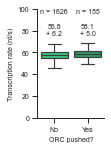

In [20]:
# Observed rates +/- ORC
protein = 'ORC'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.boxplot(x='number_ORC',y='velocity',data=df_push,order=sorted(df_push['number_ORC'].unique()),
            palette=palettes[protein][::2],fliersize=0)


#calculate number of observations
nobs = df_push['number_ORC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 95, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom')

rates = []
# fit data to normal distribution and print on plot
for num_orc in sorted(df_push['number_ORC'].unique()):
    mu, std = norm.fit(df_push[df_push['number_ORC']==num_orc]['velocity'])
    rates.append(f'{round(mu,1)}\n+ {round(std,1)}')
    
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 75, rates[tick],
    horizontalalignment='center',verticalalignment='bottom')

axes.set_xticklabels(['No','Yes'])
axes.set_ylim(0,100)
axes.set_xlabel('ORC pushed?')
axes.set_ylabel('Transcription rate (nt/s)')

# axes.set_title('T7 RNAP can push trains of MCM DHs')

sns.despine()
# plt.tight_layout()

plt.savefig(dir_out+'5J_Transcription_rates_ORC.svg',transparent=True)

### Figure 5L: ORC variance analysis
*Note*: only consider collisions in presence of ORC and archives with valid DNA count

In [21]:
# collect values
# pushed ORCs
var_push_x = list()
var_push_y = list()
# bypassed ORCs
var_bypass_x = list()
var_bypass_y = list()
# stuck ORCs
var_stuck_x = list()
var_stuck_y = list()

# pushed & bypassed
for archive in DnaMoleculeArchive.instances:

    var_push_x.extend([molecule.params['ORC_1_x_Variance'] 
                       for molecule in filter(lambda molecule:('coll_T7_1_ORC_1_push' in molecule.tags 
                                                               or 'coloc_T7_1_ORC_1_push' in molecule.tags) 
                                              and molecule.params['ORC_1_x_Variance'] < 0.6,archive.molecules)])
    var_push_y.extend([molecule.params['ORC_1_y_Variance'] 
                       for molecule in filter(lambda molecule:('coll_T7_1_ORC_1_push' in molecule.tags 
                                                               or 'coloc_T7_1_ORC_1_push' in molecule.tags) 
                                              and molecule.params['ORC_1_x_Variance'] < 0.6,archive.molecules)])

    var_bypass_x.extend([molecule.params['ORC_1_x_Variance'] 
                         for molecule in filter(lambda molecule:('coll_T7_1_ORC_1_bypass' in molecule.tags 
                                                               or 'coloc_T7_1_ORC_1_bypass' in molecule.tags) 
                                              ,archive.molecules)])
    var_bypass_y.extend([molecule.params['ORC_1_y_Variance'] 
                         for molecule in filter(lambda molecule:('coll_T7_1_ORC_1_bypass' in molecule.tags 
                                                               or 'coloc_T7_1_ORC_1_bypass' in molecule.tags) 
                                              ,archive.molecules)])
    
# stuck
for archive in SingleMoleculeArchive.instances:
    
    var_stuck_x.extend([molecule.params['x_Variance'] 
                        for molecule in filter(lambda molecule: 'accept' in molecule.tags,archive.molecules)])
    var_stuck_y.extend([molecule.params['y_Variance'] 
                        for molecule in filter(lambda molecule: 'accept' in molecule.tags,archive.molecules)])

In [22]:
from scipy import stats

In [23]:
# actual values (mean +/- SEM)
print(f"pushed ORC: {round(np.mean(var_push_x),3)} +/- {round(stats.sem(var_push_x),3)} px2")
print(f"bypassed ORC: {round(np.mean(var_bypass_x),3)} +/- {round(stats.sem(var_bypass_x),3)} px2")
print(f"stuck ORC: {round(np.mean(var_stuck_x),3)} +/- {round(stats.sem(var_stuck_x),3)} px2")

pushed ORC: 0.157 +/- 0.006 px2
bypassed ORC: 0.184 +/- 0.007 px2
stuck ORC: 0.018 +/- 0.001 px2


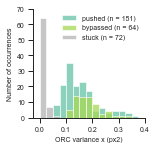

In [24]:
# x Variance (perpendicular to flow) of ORC molecules pushed vs bypassed => bypassed molecules are probably NOT stuck
fig,axes = plt.subplots(figsize=(2,2))

sns.distplot(var_push_x,bins = np.linspace(0, 0.5, 21),kde=False,ax=axes,color=palettes['qualitative'][0], hist_kws={"alpha": 0.75},
             label=f"pushed (n = {len(var_push_x)})")
sns.distplot(var_bypass_x,bins = np.linspace(0, 0.5, 21),kde=False,ax=axes,color=palettes['qualitative'][4], hist_kws={"alpha": 0.75},
             label=f"bypassed (n = {len(var_bypass_x)})")
sns.distplot(var_stuck_x,bins = np.linspace(0, 0.5, 21),kde=False,ax=axes,color=palettes['qualitative'][7], hist_kws={"alpha": 0.75},
             label=f"stuck (n = {len(var_stuck_x)})")
axes.legend(loc=1,frameon=False)
axes.set_xlim(-0.025,0.4)
axes.set_ylim(0,70)
axes.set_xlabel('ORC variance x (px2)')
axes.set_ylabel('Number of occurrences')
# axes.set_title('x variance of pushed, bypassed and stuck ORC')

sns.despine()
#plt.tight_layout()

# save
plt.savefig(dir_out+'5L_Variance_ORC_populations.svg',transparent=True)

### Figure S5K: RNAP pushes ORC over long distances
*Note*: only consider DNA w/o T7T

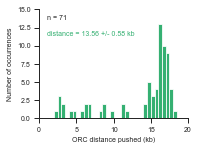

In [25]:
protein = 'ORC'
# only consider molecules with 1 MCM foci being pushed
tag_filter = 'ORC_1_push'

_plot_df = (df[(~df['t7_terminator']) & (df['number_ORC'] == 1) & (df['tags'].apply(
    lambda tags: True if re.search(tag_filter,' '.join(tags)) else False))].filter(regex=(protein+"_"),axis=1))

fig,axes = plt.subplots()

sns.distplot((_plot_df.xs('stop_site',level='properties',axis=1) -
              _plot_df.xs('start_site',level='properties',axis=1))/1000,ax=axes, 
             color=sns.desaturate(palettes[protein][1],0.75), bins = np.linspace(0, 25, 51), kde=False, hist_kws={'alpha':1})
# mean+/- sem
mean_distance = pd.melt((_plot_df.xs('stop_site',level='properties',axis=1) - 
                         _plot_df.xs('start_site',level='properties',axis=1))/1000)['value'].mean()
sem_distance = pd.melt((_plot_df.xs('stop_site',level='properties',axis=1) - 
                         _plot_df.xs('start_site',level='properties',axis=1))/1000)['value'].sem()
axes.text(0.05, 0.8, f"distance = {round(mean_distance,2)} +/- {round(sem_distance,2)} kb",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes, color=sns.desaturate(palettes[protein][1],0.75))

axes.set_xlim(0,20)
axes.set_ylim(0,15)
axes.set_xlabel('ORC distance pushed (kb)')
axes.set_ylabel('Number of occurrences')
#axes.legend(loc=0,frameon=False)

axes.text(0.05, 0.95, f"n = {len(_plot_df)}",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5K_ORC_pushed_distance.svg',transparent=True)

### Figure S5L: Pausing probability during transcription +/- ORC
*Note*: only consider DNA w/o T7T, one ORC foci and only active pushing (pauses upon T7-ORC collision are not accounted for)

In [26]:
# 1st part, df with ORC == 1, no T7T, and tags contain ORC_1_push
df_orc = df[(~df['t7_terminator']) & (df['number_ORC'] == 1) & 
            (df['tags'].apply(lambda tags: re.search('ORC_1_push', ' '.join(tags))))]['ORC_1_']
df_orc

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
tQZAZhjj8Kodbg69hpUw64           92383.0     72.0           0.0      NaN   
tqXicVtpV4xrQsVhYVxKWb           42317.3     32.0           0.0      NaN   
gGq4WfJ5PC7N45pBqRTxz3           52218.7     38.0           0.0      NaN   
uyPmJxzUXHBrpJZbmsK2rx           26382.7    107.0           0.0      NaN   
6VVQ474fpok4u9nJBSTA5f           27066.6     22.0           0.0      NaN   
...                                  ...      ...           ...      ...   
paUge3Lvdv1iAp4zPWzpJh           84374.9    150.0           1.0  618.501   
9Ew97ALhthVFdBLakBnVKn           36964.4     60.0           0.0      NaN   
pmMiPY5Nmt1frDCq3jniDA           11910.3     53.0           0.0      NaN   
eB9fWJYhNvtAipdkZHEfdf          155748.4     68.0           0.0      NaN   
jbFcCdvyk32CMKArGCefGY           43852.5     95.0           1.0   41.220   

properties                                        start_site     stop_site  
properties_details     position_on_dna recovery                             
tQZAZhjj8Kodbg69hpUw64             NaN      NaN  4876.398054  21485.670183  
tqXicVtpV4xrQsVhYVxKWb             NaN      NaN  3463.113266   9731.999655  
gGq4WfJ5PC7N45pBqRTxz3             NaN      NaN  4721.798711  13274.841442  
uyPmJxzUXHBrpJZbmsK2rx             NaN      NaN  5002.293877  21406.482022  
6VVQ474fpok4u9nJBSTA5f             NaN      NaN  5042.382379   8207.693112  
...                                ...      ...          ...           ...  
paUge3Lvdv1iAp4zPWzpJh    12419.976774    False  3968.304193  12967.133898  
9Ew97ALhthVFdBLakBnVKn             NaN      NaN  3190.476480  21563.199497  
pmMiPY5Nmt1frDCq3jniDA             NaN      NaN  4912.891140  19587.533043  
eB9fWJYhNvtAipdkZHEfdf             NaN      NaN  4735.327627  21487.796614  
jbFcCdvyk32CMKArGCefGY    15839.145353     True  5013.246056  22934.307103  

[71 rows x 8 columns]

In [27]:
# 2nd part, df with MCM == 0, ORC == 0, no T7T and T7 ==1
df_t7 = df[(~df['t7_terminator']) & (df['number_T7'] == 1) & (df['number_ORC'] == 0)]['T7_1_']
df_t7['initial_intensity'] = 0
df_t7

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
7YiVwN4gNyWwvWYq9Wy7Zw                 0     49.0           0.0      NaN   
8QZ9oo6R2uKM23d9wYkxxm                 0    126.0           1.0  454.081   
hoFR6nXBaufJrYn2DfCWCE                 0     75.0           0.0      NaN   
4cwyRaAREQUMD58dYpoHxF                 0     73.0           0.0      NaN   
jAq7a5vKStda8rPLq3xjW8                 0     55.0           0.0      NaN   
...                                  ...      ...           ...      ...   
rhvEg8qETjuqrgcRNDqGyV                 0     56.0           0.0      NaN   
orYBWmJ4NqFyRb7exbeSoj                 0     41.0           0.0      NaN   
jJWY8RLcWPPVF3jC7BwB4P                 0     49.0           0.0      NaN   
wbge6764hSdTwvxoUKiJan                 0     71.0           0.0      NaN   
uruWMsBMSQzVNUcaEbzLwG                 0     48.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
7YiVwN4gNyWwvWYq9Wy7Zw             NaN      NaN      NaN             NaN   
8QZ9oo6R2uKM23d9wYkxxm     14995.96384    False      NaN             NaN   
hoFR6nXBaufJrYn2DfCWCE             NaN      NaN      NaN             NaN   
4cwyRaAREQUMD58dYpoHxF             NaN      NaN      NaN             NaN   
jAq7a5vKStda8rPLq3xjW8             NaN      NaN      NaN             NaN   
...                                ...      ...      ...             ...   
rhvEg8qETjuqrgcRNDqGyV             NaN      NaN      NaN             NaN   
orYBWmJ4NqFyRb7exbeSoj             NaN      NaN      NaN             NaN   
jJWY8RLcWPPVF3jC7BwB4P             NaN      NaN      NaN             NaN   
wbge6764hSdTwvxoUKiJan             NaN      NaN      NaN             NaN   
uruWMsBMSQzVNUcaEbzLwG             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site  
properties_details     recovery                             
7YiVwN4gNyWwvWYq9Wy7Zw      NaN  3051.869470  15180.279496  
8QZ9oo6R2uKM23d9wYkxxm      NaN  2988.974576  15427.667681  
hoFR6nXBaufJrYn2DfCWCE      NaN  3467.775361  21960.862435  
4cwyRaAREQUMD58dYpoHxF      NaN  3173.260843  21349.301206  
jAq7a5vKStda8rPLq3xjW8      NaN  4555.834512  19759.499272  
...                         ...          ...           ...  
rhvEg8qETjuqrgcRNDqGyV      NaN  2285.328725  21798.999102  
orYBWmJ4NqFyRb7exbeSoj      NaN  3780.814210  21146.889602  
jJWY8RLcWPPVF3jC7BwB4P      NaN  2679.491711  20171.105331  
wbge6764hSdTwvxoUKiJan      NaN  3294.591685  22054.867560  
uruWMsBMSQzVNUcaEbzLwG      NaN  3138.113727  18009.627505  

[768 rows x 11 columns]

In [28]:
df_pause = pd.concat([df_orc, df_t7])
df_pause

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
tQZAZhjj8Kodbg69hpUw64           92383.0     72.0           0.0      NaN   
tqXicVtpV4xrQsVhYVxKWb           42317.3     32.0           0.0      NaN   
gGq4WfJ5PC7N45pBqRTxz3           52218.7     38.0           0.0      NaN   
uyPmJxzUXHBrpJZbmsK2rx           26382.7    107.0           0.0      NaN   
6VVQ474fpok4u9nJBSTA5f           27066.6     22.0           0.0      NaN   
...                                  ...      ...           ...      ...   
rhvEg8qETjuqrgcRNDqGyV               0.0     56.0           0.0      NaN   
orYBWmJ4NqFyRb7exbeSoj               0.0     41.0           0.0      NaN   
jJWY8RLcWPPVF3jC7BwB4P               0.0     49.0           0.0      NaN   
wbge6764hSdTwvxoUKiJan               0.0     71.0           0.0      NaN   
uruWMsBMSQzVNUcaEbzLwG               0.0     48.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
tQZAZhjj8Kodbg69hpUw64             NaN      NaN      NaN             NaN   
tqXicVtpV4xrQsVhYVxKWb             NaN      NaN      NaN             NaN   
gGq4WfJ5PC7N45pBqRTxz3             NaN      NaN      NaN             NaN   
uyPmJxzUXHBrpJZbmsK2rx             NaN      NaN      NaN             NaN   
6VVQ474fpok4u9nJBSTA5f             NaN      NaN      NaN             NaN   
...                                ...      ...      ...             ...   
rhvEg8qETjuqrgcRNDqGyV             NaN      NaN      NaN             NaN   
orYBWmJ4NqFyRb7exbeSoj             NaN      NaN      NaN             NaN   
jJWY8RLcWPPVF3jC7BwB4P             NaN      NaN      NaN             NaN   
wbge6764hSdTwvxoUKiJan             NaN      NaN      NaN             NaN   
uruWMsBMSQzVNUcaEbzLwG             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site  
properties_details     recovery                             
tQZAZhjj8Kodbg69hpUw64      NaN  4876.398054  21485.670183  
tqXicVtpV4xrQsVhYVxKWb      NaN  3463.113266   9731.999655  
gGq4WfJ5PC7N45pBqRTxz3      NaN  4721.798711  13274.841442  
uyPmJxzUXHBrpJZbmsK2rx      NaN  5002.293877  21406.482022  
6VVQ474fpok4u9nJBSTA5f      NaN  5042.382379   8207.693112  
...                         ...          ...           ...  
rhvEg8qETjuqrgcRNDqGyV      NaN  2285.328725  21798.999102  
orYBWmJ4NqFyRb7exbeSoj      NaN  3780.814210  21146.889602  
jJWY8RLcWPPVF3jC7BwB4P      NaN  2679.491711  20171.105331  
wbge6764hSdTwvxoUKiJan      NaN  3294.591685  22054.867560  
uruWMsBMSQzVNUcaEbzLwG      NaN  3138.113727  18009.627505  

[839 rows x 11 columns]

In [29]:
df_pause['number_ORC'] = df_pause['initial_intensity'].apply(estimate_bleaching)
df_pause

properties             initial_intensity lifetime number_pauses  pause_1  \
properties_details                                              duration   
tQZAZhjj8Kodbg69hpUw64           92383.0     72.0           0.0      NaN   
tqXicVtpV4xrQsVhYVxKWb           42317.3     32.0           0.0      NaN   
gGq4WfJ5PC7N45pBqRTxz3           52218.7     38.0           0.0      NaN   
uyPmJxzUXHBrpJZbmsK2rx           26382.7    107.0           0.0      NaN   
6VVQ474fpok4u9nJBSTA5f           27066.6     22.0           0.0      NaN   
...                                  ...      ...           ...      ...   
rhvEg8qETjuqrgcRNDqGyV               0.0     56.0           0.0      NaN   
orYBWmJ4NqFyRb7exbeSoj               0.0     41.0           0.0      NaN   
jJWY8RLcWPPVF3jC7BwB4P               0.0     49.0           0.0      NaN   
wbge6764hSdTwvxoUKiJan               0.0     71.0           0.0      NaN   
uruWMsBMSQzVNUcaEbzLwG               0.0     48.0           0.0      NaN   

properties                                       pause_2                  \
properties_details     position_on_dna recovery duration position_on_dna   
tQZAZhjj8Kodbg69hpUw64             NaN      NaN      NaN             NaN   
tqXicVtpV4xrQsVhYVxKWb             NaN      NaN      NaN             NaN   
gGq4WfJ5PC7N45pBqRTxz3             NaN      NaN      NaN             NaN   
uyPmJxzUXHBrpJZbmsK2rx             NaN      NaN      NaN             NaN   
6VVQ474fpok4u9nJBSTA5f             NaN      NaN      NaN             NaN   
...                                ...      ...      ...             ...   
rhvEg8qETjuqrgcRNDqGyV             NaN      NaN      NaN             NaN   
orYBWmJ4NqFyRb7exbeSoj             NaN      NaN      NaN             NaN   
jJWY8RLcWPPVF3jC7BwB4P             NaN      NaN      NaN             NaN   
wbge6764hSdTwvxoUKiJan             NaN      NaN      NaN             NaN   
uruWMsBMSQzVNUcaEbzLwG             NaN      NaN      NaN             NaN   

properties                        start_site     stop_site number_ORC  
properties_details     recovery                                        
tQZAZhjj8Kodbg69hpUw64      NaN  4876.398054  21485.670183          1  
tqXicVtpV4xrQsVhYVxKWb      NaN  3463.113266   9731.999655          1  
gGq4WfJ5PC7N45pBqRTxz3      NaN  4721.798711  13274.841442          1  
uyPmJxzUXHBrpJZbmsK2rx      NaN  5002.293877  21406.482022          1  
6VVQ474fpok4u9nJBSTA5f      NaN  5042.382379   8207.693112          1  
...                         ...          ...           ...        ...  
rhvEg8qETjuqrgcRNDqGyV      NaN  2285.328725  21798.999102          0  
orYBWmJ4NqFyRb7exbeSoj      NaN  3780.814210  21146.889602          0  
jJWY8RLcWPPVF3jC7BwB4P      NaN  2679.491711  20171.105331          0  
wbge6764hSdTwvxoUKiJan      NaN  3294.591685  22054.867560          0  
uruWMsBMSQzVNUcaEbzLwG      NaN  3138.113727  18009.627505          0  

[839 rows x 12 columns]

In [30]:
df_pause.groupby('number_ORC').describe()['number_pauses']

properties_details                                                    
                    count      mean       std  min  25%  50%  75%  max
number_ORC                                                            
0                   768.0  0.125000  0.350079  0.0  0.0  0.0  0.0  2.0
1                    70.0  0.142857  0.352454  0.0  0.0  0.0  0.0  1.0

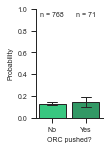

In [31]:
protein = 'ORC'

fig,axes = plt.subplots(figsize=(1.2, 2))

sns.barplot(x='number_ORC',y='number_pauses',data=df_pause,order=[0,1],
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')
axes.set_xlabel('ORC pushed?')
axes.set_ylabel('Probability')
axes.set_xticklabels(['No','Yes'])
#axes.set_title(f'T7 pause frequency')
axes.set_ylim([0,1])
#calculate number of observations
nobs = df_pause['number_ORC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 0.95, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

sns.despine()
#plt.tight_layout()

#save
plt.savefig(dir_out+'S5L_pause_probability_ORC.svg',transparent=True)

### Figure S5M: Pause recovery +/- ORC
*Note*: only consider DNA w/o T7T, one ORC foci and only active pushing (pauses upon T7-ORC collision are not accounted for)


In [32]:
df_pause['number_pauses'] = df_pause['number_pauses'].fillna(0)

In [33]:
_plot_df = pd.DataFrame(columns=['duration','recovery','number_ORC'])
for index in df_pause.index:
    # check how many pauses we got
    
    for i in range(1,int(df_pause.loc[index,('number_pauses','')]+1)):

        _temp_df = pd.DataFrame(data=[[df_pause.loc[index,('pause_'+str(i),'duration')],
                                      df_pause.loc[index,('pause_'+str(i),'recovery')],
                                      df_pause.loc[index,('number_ORC','')]]],
                                      columns=['duration','recovery','number_ORC'])
        _plot_df = pd.concat([_plot_df,_temp_df])
    
_plot_df = _plot_df.convert_dtypes()
_plot_df.head()

,duration,recovery,number_ORC
0,662.201,False,1
0,591.261,False,1
0,312.990,False,1
0,570.601,False,1
0,78.780,True,1


In [34]:
_plot_df['recovery_bin'] = _plot_df['recovery'].apply(lambda recovery: 1 if recovery else 0)
_plot_df.head()

,duration,recovery,number_ORC,recovery_bin
0,662.201,False,1,0
0,591.261,False,1,0
0,312.990,False,1,0
0,570.601,False,1,0
0,78.780,True,1,1


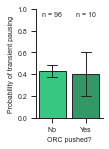

In [35]:
protein = 'ORC'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.barplot(x='number_ORC',y='recovery_bin', data=_plot_df,
            order=sorted(df_pause['number_ORC'].unique()),
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')

axes.set_ylim(0,1)
axes.set_xlabel('ORC pushed?')
axes.set_ylabel('Probability of transient pausing')
axes.set_xticklabels(['No','Yes'])
#axes.set_title('Recovery from transcription pauses')

#calculate number of observations
nobs = _plot_df['number_ORC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    transform=axes.transAxes, axes.text(pos[tick], 0.95, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

#axes.set_xticklabels(['No','Yes'])

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5M_pause_recovery_vs_#ORC.svg',transparent=True)


### Figure S5N: Pause durations (only transient pauses)
*Note*: only consider DNA w/o T7T, one ORC foci and only active pushing (pauses upon T7-ORC collision are not accounted for)

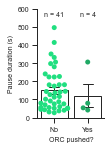

In [36]:
protein = 'ORC'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.swarmplot(x='number_ORC',y='duration', data=_plot_df[_plot_df['recovery']],
              order=sorted(df_pause['number_ORC'].unique()), palette=palettes[protein][::2], ax=axes)
sns.barplot(x='number_ORC',y='duration', data=_plot_df[_plot_df['recovery']],
            order=sorted(df_pause['number_ORC'].unique()), facecolor=(1, 1, 1, 0),
            palette=palettes[protein][::2],lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')

axes.set_ylim(0,600)
axes.set_xlabel('ORC pushed?')
axes.set_ylabel('Pause duration (s)')
axes.set_xticklabels(['No','Yes'])
#axes.set_title('Recovery from transcription pauses')

#calculate number of observations
nobs = _plot_df[_plot_df['recovery']]['number_ORC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    transform=axes.transAxes, axes.text(pos[tick], 570, nobs[tick],
    horizontalalignment='center',verticalalignment='center')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5N_pause_duration_ORC.svg',transparent=True)
